In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import copy 

import numpy as np 

import multiprocessing
from multiprocessing import Pool
from contextlib import closing

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# Put the fit_sersic.py, parameters.py, and priors.py files in the same folder
from fit_sersic import Sersic, display_model_1d
from fit_sersic import config_params, prof_curvefit, update_params 
from fit_sersic import emcee_fit_one_sersic, ln_probability, visual_emcee

# Install emcee sampling tool: `pip install --upgrade emcee`
# To visualize the result, also need `corner`: `pip install --upgrade corner`
rcParams.update({'font.size': 25})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Function to generate Sersic profile

In [10]:
# To get a Sersic profile 
n_ser, i_0, r_e = 4.0, 1.0, 10.0
r = np.arange(1.0, 100.0, 10)

Sersic(r, n_ser, i_0, r_e)

array([2.86889935e+01, 8.31159225e-01, 2.09505908e-01, 8.15018238e-02,
       3.90127031e-02, 2.11552058e-02, 1.24818758e-02, 7.83082460e-03,
       5.14897177e-03, 3.51390901e-03])

In [11]:
from astropy.modeling import models, fitting
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pylab import figure, text, scatter, show
from math import factorial
import h5py

### Example from Rajdipa

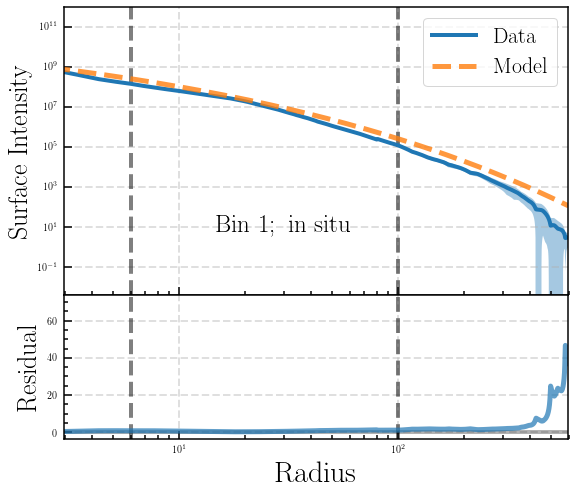

In [4]:
rad = np.load('/Users/RAJ/Downloads/radii.npy')
rho = np.load('/Users/RAJ/Downloads/boot_median_ins_bin_1.npy')
err = np.load('/Users/RAJ/Downloads/boot_median_ins_uncern_bin_1.npy')

# Overplot the profile and a random model
display_model_1d(rad, rho, err, model=Sersic(rad, 4.0, 1e8, 10.0), 
                 info=r'$\rm Bin\ 1;\ in\ situ$', x_lim=(2.99, 599))

### Fitting the profile using `emcee`

#### We can do `astropy` style simple fitting too using L-M algorithm

In [5]:
# Normalize the input profile and uncertainty, decide the fitting range, and
# setup the initial parameter ranges for fitting.
rho_norm, err_norm, params = config_params(rad, rho, err, min_r=6.0, max_r=120.0)

# Fit the Sersic profile using scipy.curvefit() to get the simple
# best-fit parameters (pbest) and the associated covariance matrix (pcov)
# The later can be used to estimate parameter errors.
pbest, pcov = prof_curvefit(Sersic, rad, rho_norm, err_norm, params)
print("Best-fit Sersic parameters from curvefit:", pbest)
print("Error of Sersic parameters from curvefit:", np.sqrt(np.diag(pcov)))

# Update the parameter ranges based on the best-fit result
params_update = update_params(pbest, pcov, nsig=5.0)

Best-fit Sersic parameters from curvefit: [  3.11935121 102.08411627  10.52397826]
Error of Sersic parameters from curvefit: [0.08059505 6.60584457 0.3012413 ]


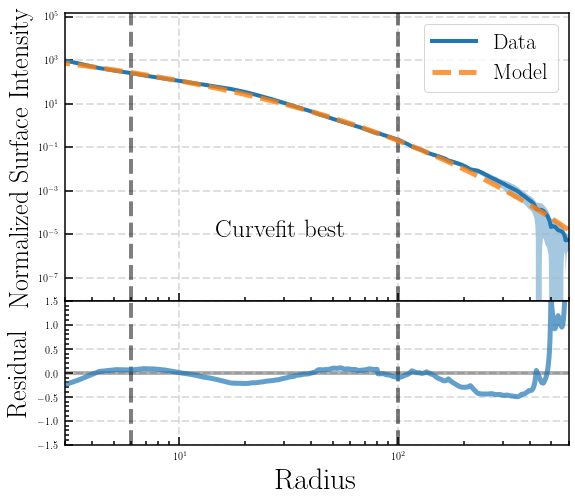

In [6]:
# Overplot the profile and the best-fit model from curvefit
# It is already not bad!
display_model_1d(rad, rho_norm, err_norm, 
                 model=Sersic(rad, pbest[0], pbest[1], pbest[2]), normed=True,
                 info=r'$\rm Curvefit\ best$', x_lim=(2.99, 599), res_lim=(-1.5, 1.5))

#### Sampling the posterior distributions of parameters

In [7]:
# ln_probability is the function to evaluate the likelihood of a set of parameters
ln_probability(
    params_update.sample()[0], params_update, rad, rho_norm, err_norm)

-600.0024845983276

In [8]:
# n_walker should at least > n_dim ** 2
n_walkers = 128
n_burnin, n_samples = 500, 100

# You might want to take advantage of the multiple processors you have
n_jobs = multiprocessing.cpu_count()

# Burn-in
with closing(Pool(processes=n_jobs)) as pool:
    results, sampler = emcee_fit_one_sersic(
        rad, rho, err, pool=pool, n_walkers=n_walkers, n_burnin=n_burnin,
        n_samples=n_samples)

Best-fit Sersic parameters from curvefit: [  3.11935121 102.08411627  10.52397826]
Error of Sersic parameters from curvefit: [0.08059505 6.60584457 0.3012413 ]
# Running burn-in step...


100%|██████████| 500/500 [01:10<00:00,  7.10it/s]


IndexError: index 199 is out of bounds for axis 0 with size 128

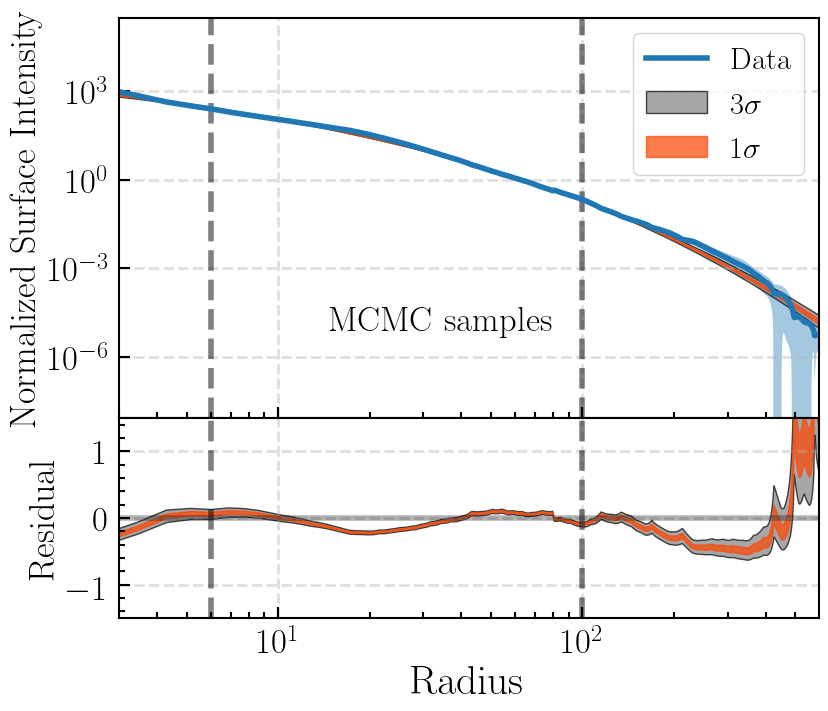

In [48]:
# Select the samples from the last 20 steps
# This will result in 20 x n_walkers profiles: in this example, it is 2560
prof_samples = [
    Sersic(rad, pos[0], pos[1], pos[2]) for 
    pos in results['chains'][:, -20:, :].reshape([-1, 3])]

display_model_1d(rad, results['prof_norm'], results['err_norm'], 
                 samples=prof_samples, normed=True,
                 info=r'$\rm MCMC\ samples$', x_lim=(2.99, 599), res_lim=(-1.5, 1.5))

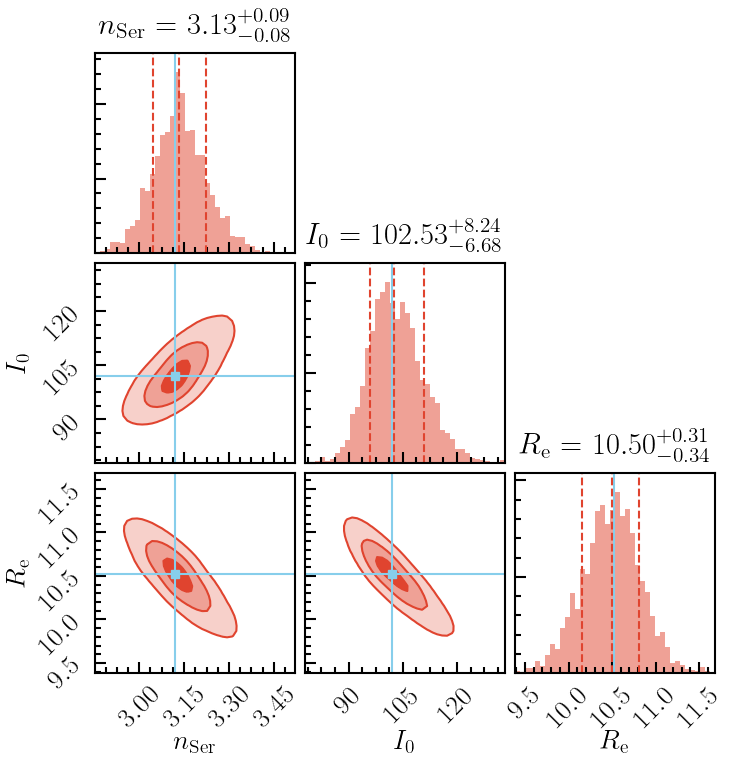

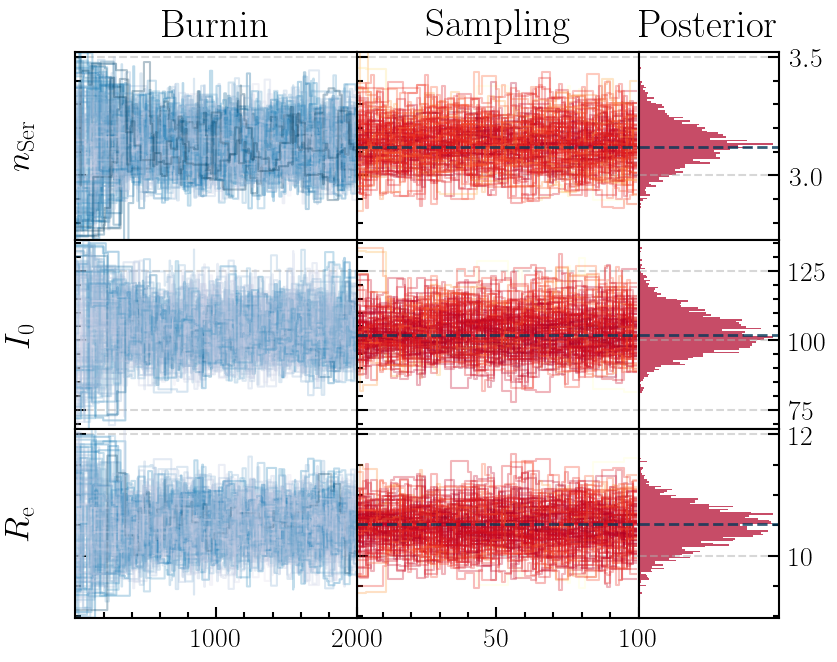

In [46]:
# Visualize the results
_ = visual_emcee(results, burnin=burnin)

### Test the whole sample

In [50]:
all_profs = np.load('data/rajdipa/summary_median.npy')

rad_kpc = all_profs['rad_kpc']

In [49]:
# n_walker should at least > n_dim ** 2
n_walkers = 128
n_burnin, n_samples = 500, 200

# You might want to take advantage of the multiple processors you have
n_jobs = multiprocessing.cpu_count()

  0%|          | 0/500 [00:00<?, ?it/s]

Best-fit Sersic parameters from curvefit: [ 2.99484521 86.48437021 11.0863557 ]
Error of Sersic parameters from curvefit: [ 0.18310345 10.07804635  0.63510337]
# Running burn-in step...


100%|██████████| 500/500 [00:38<00:00, 13.10it/s]


#------------------------------------------------------
#  Mean acceptance fraction 0.010968750000000003
#------------------------------------------------------
#  Best ln(Probability):   -16.50584
[ 2.99880487 86.19055513 11.08733566]
#------------------------------------------------------
#  Best parameters (mean):
[ 3.05837934 90.66275715 10.91103087]
#------------------------------------------------------
(2.996405175301041, 0.46318674939899607, 0.40810203915692256)
(89.76992027972527, 20.399358077211247, 26.409044521751156)
(10.926074145014928, 1.4562250411789837, 1.1952656083862614)
#------------------------------------------------------
# Running final sampling step...


100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


#------------------------------------------------------
#  Mean acceptance fraction 0.38570312500000004
#------------------------------------------------------
#  Best ln(Probability):   -16.50424
[ 2.98645973 85.74625531 11.12554783]
#------------------------------------------------------
#  Best parameters (mean):
[ 3.04221268 89.42098429 10.94194541]
#------------------------------------------------------
(3.0371468725128277, 0.21530849126469898, 0.1832155503659476)
(88.51675536146152, 12.012176599096009, 10.149237242039646)
(10.94404868059284, 0.6496362552736823, 0.6682818093654177)
#------------------------------------------------------


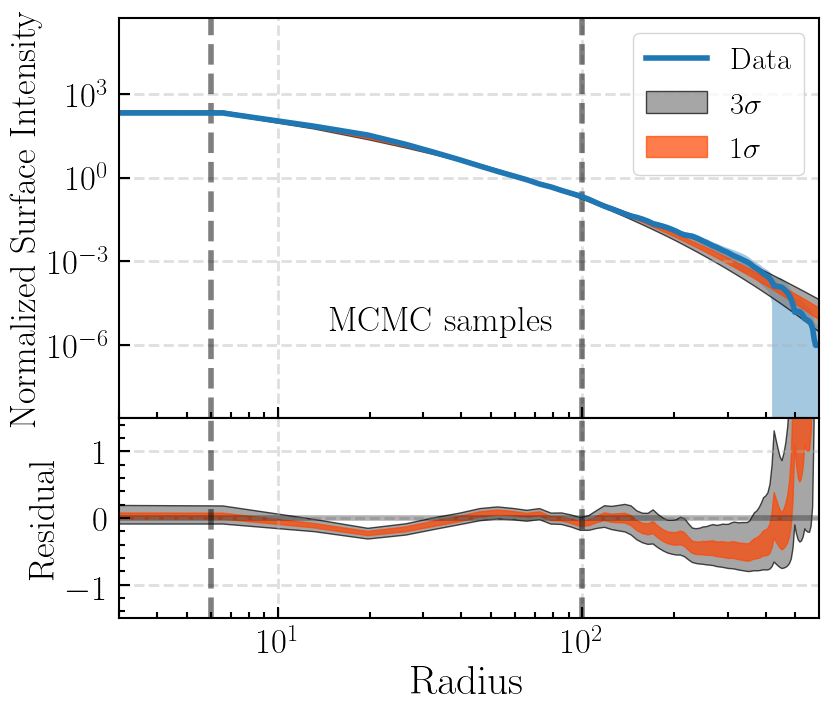

In [51]:
# Fitting the in-situ profile for bin 1
with closing(Pool(processes=n_jobs)) as pool:
    bin_1_ins, sampler = emcee_fit_one_sersic(
        rad_kpc, all_profs['bin_1_prof_ins'], all_profs['bin_1_err_ins'], 
        pool=pool, n_walkers=n_walkers, n_burnin=n_burnin, n_samples=n_samples)
    
prof_samples = [
    Sersic(rad_kpc, pos[0], pos[1], pos[2]) for 
    pos in bin_1_ins['chains'][:, -20:, :].reshape([-1, 3])]

display_model_1d(rad_kpc, bin_1_ins['prof_norm'], bin_1_ins['err_norm'], 
                 samples=prof_samples, normed=True,
                 info=r'$\rm MCMC\ samples$', x_lim=(2.99, 599), 
                 res_lim=(-1.5, 1.5))

  0%|          | 0/500 [00:00<?, ?it/s]

Best-fit Sersic parameters from curvefit: [ 4.67200223 43.93138159 12.19812205]
Error of Sersic parameters from curvefit: [0.18636988 3.32704023 0.44481823]
# Running burn-in step...


100%|██████████| 500/500 [00:49<00:00, 10.07it/s]


#------------------------------------------------------
#  Mean acceptance fraction 0.036015624999999996
#------------------------------------------------------
#  Best ln(Probability):    -9.78391
[ 4.68614853 43.96771553 12.19198376]
#------------------------------------------------------
#  Best parameters (mean):
[ 4.73022364 45.18890016 12.13293523]
#------------------------------------------------------
(4.777100151679008, 0.41917052873167826, 0.42824715213861264)
(45.28539347830011, 8.86550306820915, 7.5535979696471)
(12.026139512583931, 1.064300512545488, 0.9796069004260914)
#------------------------------------------------------
# Running final sampling step...


100%|██████████| 200/200 [00:30<00:00,  6.55it/s]


#------------------------------------------------------
#  Mean acceptance fraction 0.3543359375
#------------------------------------------------------
#  Best ln(Probability):    -9.78296
[ 4.6540337  43.48563371 12.25489922]
#------------------------------------------------------
#  Best parameters (mean):
[ 4.72263627 45.3591564  12.10360981]
#------------------------------------------------------
(4.733724302092199, 0.4172658817530781, 0.38324969966567135)
(44.782812211700005, 7.448085868054974, 6.721423756641244)
(12.062150728120113, 0.9658750078602765, 0.8523970706881663)
#------------------------------------------------------


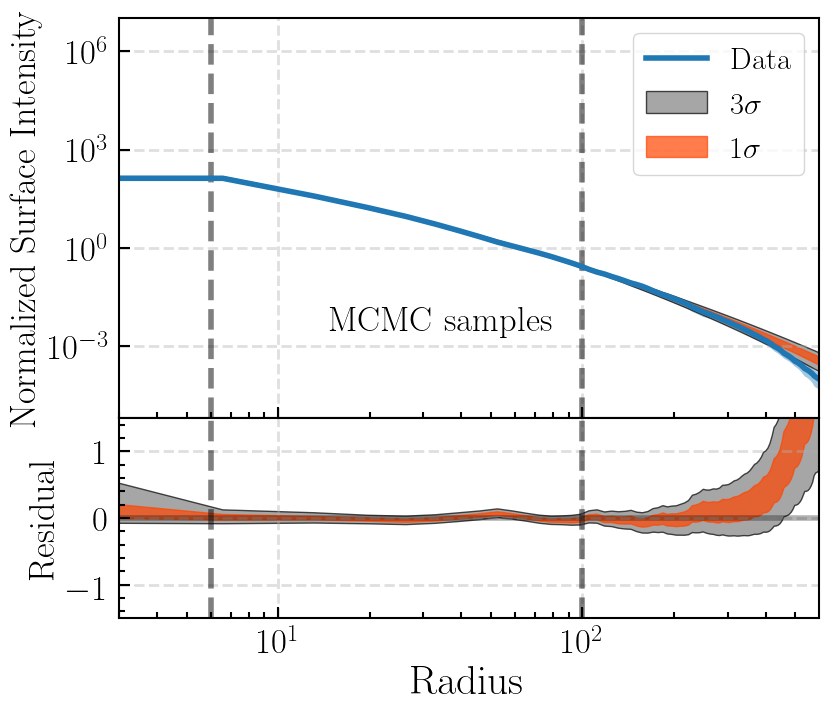

In [52]:
# Fitting the ex-situ profile for bin 1
with closing(Pool(processes=n_jobs)) as pool:
    bin_1_exs, sampler = emcee_fit_one_sersic(
        rad_kpc, all_profs['bin_1_prof_exs'], all_profs['bin_1_err_exs'], 
        pool=pool, n_walkers=n_walkers, n_burnin=n_burnin, n_samples=n_samples)
    
prof_samples = [
    Sersic(rad_kpc, pos[0], pos[1], pos[2]) for 
    pos in bin_1_exs['chains'][:, -20:, :].reshape([-1, 3])]

display_model_1d(rad_kpc, bin_1_exs['prof_norm'], bin_1_exs['err_norm'], 
                 samples=prof_samples, normed=True,
                 info=r'$\rm MCMC\ samples$', x_lim=(2.99, 599), 
                 res_lim=(-1.5, 1.5))

In [56]:
import corner

### Example of overplotting two corner plots

In [81]:
rcParams.update({'font.size': 20})

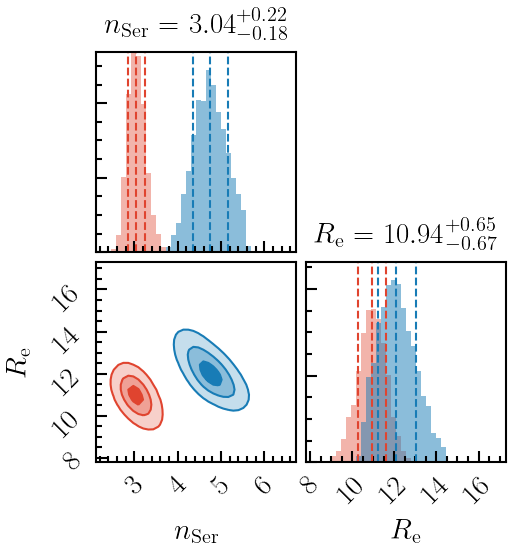

In [109]:
# Only plot the Sersic index and Re
bin1_ins_n_re = bin1_ins['samples'][:, [0,2]]
bin1_exs_n_re = bin1_exs['samples'][:, [0,2]]

params_label = [r'$n_{\rm Ser}$', r'$R_{\rm e}$']

# To get the correct ranges for the plot, you need to combine all the samples you want to
# plot
all_samples = np.vstack([bin1_ins_n_re, bin1_exs_n_re])

# Get the min and max ranges for Sersic index and Re
min_ranges = np.nanmin(all_samples, axis=0)
max_ranges = np.nanmax(all_samples, axis=0)

# X-Y ranges of the corner plot
corner_ranges = [(min_ranges[0] * 0.9, max_ranges[0] * 1.2), 
                 (min_ranges[1] * 0.9, max_ranges[1] * 1.2)]

# Also need to adjust the weight
ns_hist_1, _ = np.histogram(bin1_ins_n_re[:, 0], bins=40) 
ns_hist_2, _ = np.histogram(bin1_exs_n_re[:, 0], bins=40) 
re_hist_1, _ = np.histogram(bin1_ins_n_re[:, 1], bins=40) 
re_hist_2, _ = np.histogram(bin1_exs_n_re[:, 1], bins=40) 

hist_weight = np.max(
    [np.max(ns_hist_1) / np.max(ns_hist_2), np.max(re_hist_1) / np.max(re_hist_2)])

# Colors for in-situ and ex-situ
ORG = plt.get_cmap('OrRd')
BLU = plt.get_cmap('PuBu')


fig_bin1 = corner.corner(
        bin1_ins_n_re,
        bins=40, color=ORG(0.7),
        range=corner_ranges,
        smooth=2, labels=params_label,
        label_kwargs={'fontsize': 22},
        quantiles=[0.16, 0.5, 0.84],
        levels=[0.16, 0.50, 0.84],
        plot_contours=True,
        fill_contours=True,
        show_titles=True,
        title_kwargs={"fontsize": 21},
        hist_kwargs={"histtype": 'stepfilled', "alpha": 0.4,
                     "edgecolor": "none", "density": False},
        use_math_text=True,
        **{'title_fmt': '.2f', 'ranges': corner_ranges, 
           'plot_datapoints': False}
        )

_ = corner.corner(
        bin1_exs_n_re ,
        fig=fig_bin1,
        range=corner_ranges,
        bins=40, color=BLU(0.7),
        smooth=2, labels=params_label,
        label_kwargs={'fontsize': 21},
        quantiles=[0.16, 0.5, 0.84],
        levels=[0.16, 0.50, 0.84],
        plot_contours=True,
        fill_contours=True,
        show_titles=False,
        hist_kwargs={"histtype": 'stepfilled', "alpha": 0.5,
                     "edgecolor": "none", "density": False},
        weights=np.ones(len(bin1_ins_n_re)) * hist_weight,
        use_math_text=True,
        **{'title_fmt': '.2f', 'ranges': corner_ranges, 
           'plot_datapoints': False}
        )

1.577223088923557